In [ ]:
import matplotlib.pyplot as plt
import torch
from mdm.watermark import ImageWatermark, create_orthonormal_basis
from edm import dnnlib

In [2]:
def build_dataset(name):
    assert name in ["ffhq", "afhqv2"]
    path = {
        "ffhq": 'data/ffhq-64x64.zip',
        "afhqv2": 'data/afhqv2-64x64.zip',
    }.get(name)

    kwargs = {
        'class_name': 'edm.training.dataset.ImageFolderDataset',
        'path': path,
        'use_labels': False,
        'xflip': False,
        'cache': True,
        'resolution': 64,
        'max_size': 15803
    }
    return dnnlib.util.construct_class_by_name(**kwargs)

def imshows(imgs, ax_length_in=2, ncol=8, nrow=4):
    figsize = (ax_length_in*ncol, ax_length_in*nrow)
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    axs = fig.subplots(nrow, ncol).reshape(-1)
    for ax in axs: ax.set(xticks=[], yticks=[])

    for ax, img in zip(axs, imgs[:len(axs)]):
        img = (img + 1) / 2
        img = img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        ax.imshow(img)

In [3]:
device = "cuda"

dataset_name = "afhqv2"
dim = 3*64*64
dataset = build_dataset(dataset_name)
print(f"Dataset={dataset_name}, size={len(dataset)}")

# hyperparameter for watermark
n_constraint, upper, lower = 100, 0.9, -0.9
A = create_orthonormal_basis(dim, n_constraint)
watermark = ImageWatermark(dataset_name, orthn_basis=A, upper=upper, lower=lower, device=device)

Dataset=afhqv2, size=15803


gramschmidt: 100%|██████████| 99/99 [00:01<00:00, 82.48it/s] 


Original dataset: images violated constraints= 0.9321%


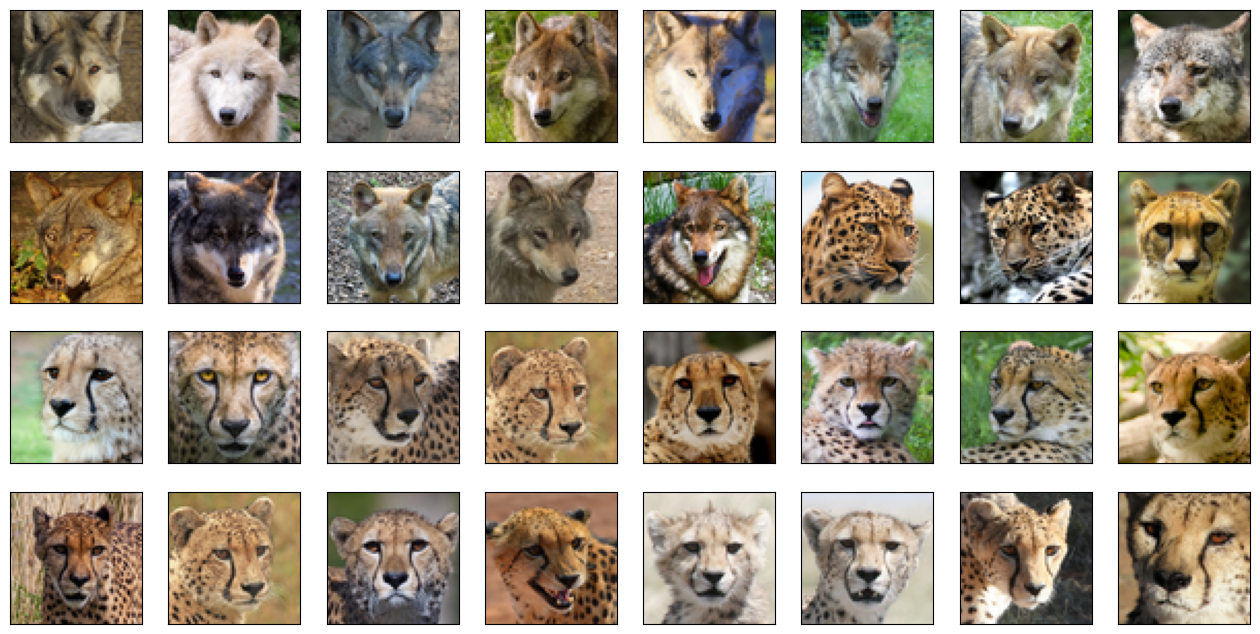

In [4]:
n_infeasible = 0
data_loader = torch.utils.data.DataLoader(dataset, batch_size=512)
for images, _ in data_loader:
    # [0, 255] -> [-1, 1]
    images = images.to(device).to(torch.float32) / 127.5 - 1
    infeasible = ~watermark.detact(images).cpu()
    n_infeasible += infeasible.sum()

print(f"Original dataset: images violated constraints={n_infeasible / len(dataset): .4f}%")
imshows(images) # plot last batch

Watermarked dataset: images violated constraints= 0.0000%


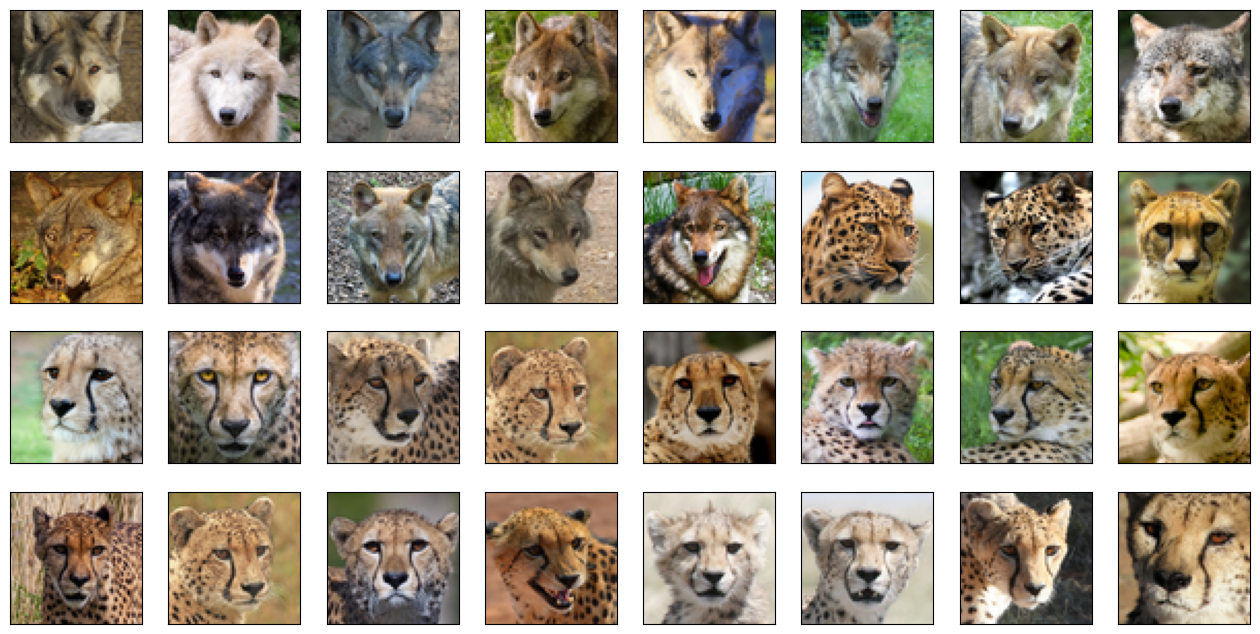

In [5]:
n_infeasible = 0
data_loader = torch.utils.data.DataLoader(dataset, batch_size=512)
for images, _ in data_loader:
    # [0, 255] -> [-1, 1]
    images = images.to(device).to(torch.float32) / 127.5 - 1

    watermarked_images = watermark(images)
    infeasible = ~watermark.detact(watermarked_images).cpu()
    n_infeasible += infeasible.sum()

print(f"Watermarked dataset: images violated constraints={n_infeasible / len(dataset): .4f}%")
imshows(images) # plot last batch